# Financial Risk Forecasting using GARCH-t(1,1) model 

In [1]:
#install.packages(c("quantmod","moments","MASS","metRology","rugarch","data.table","lubridate","ggplot2"))
# I have these libraries already pre-installed on my PC, so no need to install them again. They can be installed using the above command.

# Loading the libraries into the R environment
library(quantmod)
library(moments)
library(MASS)
library(metRology)
library(rugarch)
library(data.table)
library(lubridate)
library(ggplot2)

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'metRology'


The following objects are masked from 'package:base':

    cbind, rbind


Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma



Attaching package: 'data.table'


The following objects are masked from 'package:xts':

    first, last



Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
#Extracting the NIFTY50 Index data from "Yahoo Finance"
NSE<-getSymbols("^NSEI",src="yahoo",auto.assign=FALSE)
NSE <- NSE["2011-01-01/2021-12-31"]

#Keeping only the Adjusted CLose Price Column for Returns Calculation
NSE<-NSE$NSEI.Adjusted

NSE<-na.omit(NSE)
names(NSE)<-"Adjusted Close Price"


Warning message:
"^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


In [3]:
#Calculating Log Daily Returns
logret<-diff(log(NSE))[-1]
names(logret)<-"Returns"

#Calculating Discrete Daily Returns
ret<-exp(logret)-1
names(ret)<-"Returns"

In [4]:
round(head(logret,2),6)
round(head(ret,2),6)

             Returns
2011-01-04 -0.001829
2011-01-05 -0.010887

             Returns
2011-01-04 -0.001827
2011-01-05 -0.010828

In [5]:
#So, we can observe that there is very minute difference between log-returns and actual returns for small returns.

#we can use apply.weekly, apply.monthly, apply.quarterly, apply.yearly functions to calculate log weekly,monthly, 
#quarterly and yearly returns respectively.

logret.w<-apply.weekly(logret,sum)
round(head(logret.w,2),6)

             Returns
2011-01-07 -0.041955
2011-01-14 -0.043271

In [6]:
ret.w <- exp(logret.w)-1
round(head(ret.w,2),6)

             Returns
2011-01-07 -0.041087
2011-01-14 -0.042348

In [7]:
logret.m<-apply.weekly(logret,sum)
ret.m<-exp(logret.m)-1
logret.q<-apply.quarterly(logret,sum)
ret.q<-exp(logret.q)-1
logret.y<-apply.yearly(logret,sum)
ret.y<-exp(logret.y)-1

In [8]:
mu<-mean(logret)
sig<-sd(logret)

mu
sig

[1] 0.0003851817

[1] 0.0110696

In [9]:
rvec<-as.vector(logret)

#Estimating VaR and ES at 95% Confidence Level using Normal Distribution
VaR1<-qnorm(0.05,mu,sig)
ES1<-mu-sig*dnorm(qnorm(0.05,0,1),0,1)/0.05

In [10]:
cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR1,6), "\n", sep = " ")
cat("ES:", round(ES1,6), sep=" ")

At 95% Confidence Interval
VaR: -0.017823 
ES: -0.022448

In [11]:
#Using rnorm function to generate a random sample for Simulation from Normal distribution with the above calculated 
#mean and Standard Deviation

rvec2<-rnorm(100000,mu,sig)
alpha<-0.05
VaR2<-quantile(rvec2,alpha)
ES2<-mean(rvec2[rvec2<VaR2])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR2,6), "\n", sep = " ")
cat("ES:", round(ES2,6), sep=" ")

At 95% Confidence Interval
VaR: -0.017843 
ES: -0.022479

In [12]:
#Using raw log returns data for Simulation
RNGkind(sample.kind="Rounding")
set.seed(123789)
rvec3<-sample(rvec,100000,replace=TRUE)
VaR3<-quantile(rvec3,alpha)
ES3<-mean(rvec3[rvec3<VaR3])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR3,6), "\n", sep = " ")
cat("ES:", round(ES3,6), sep=" ")

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


At 95% Confidence Interval
VaR: -0.016798 
ES: -0.025429

In [13]:
#Calculating the skewness and kurtosis from moments library of the log return data to check whether the Normal 
#distribution is a perfect fit for the data.

cat("Skewness:", skewness(rvec), "\n", sep=" ")
cat("Kurtosis:", kurtosis(rvec), sep=" ")

#Performing the Jarque Bera Normality test to check whether Normal Distribution is a good approximation for modeling the data.
jarque.test(rvec)

Skewness: -1.004661 
Kurtosis: 17.96413


	Jarque-Bera Normality Test

data:  rvec
JB = 25551, p-value < 2.2e-16
alternative hypothesis: greater


In [14]:
# Since the skewness is negative which means the data is left skewed, as well as the kurtosis is also very big whereas the 
# skewness for normal distribution is 0 and the coefficient of kurtosis is 3 and the JB value is also quite big,which shows that 
# the Normal Distribution is not a perfect fit for the data.

# We know that standard normal distribution is a specific case of Student-T Distribution when the degree of freedoms becomes 
# infinite. So, instead of using the Normal Distribution, using rescaled Student-T Distribution which can manage leptokurtosis 
# because of adjustable degrees of freedom parameter.

#Use of metRology librray here to estimate the parameters using Lielihood function while fitting our data into a specified distribution
t.fit<-fitdistr(rvec,"t",start=list(m=mean(rvec), s=sd(rvec), df= 4 + 6/(kurtosis(rvec)-3)), lower=c(-1,0.001,3))


#Making rescaled Student-T Distribution using meTrology package
RNGkind(sample.kind="Rounding")
set.seed(123789)

rvec4<-rt.scaled(100000,mean=t.fit$estimate[1],sd=t.fit$estimate[2],df=t.fit$estimate[3])
VaR4<-unname(quantile(rvec4,alpha))
ES4<-mean(rvec4[rvec4<VaR4])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR4,6), "\n", sep = " ")
cat("ES:", round(ES4,6), sep=" ")

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


At 95% Confidence Interval
VaR: -0.015628 
ES: -0.023165

In [15]:
#Calculating 10 lays horizon VaR and ES using simulation from raw log returns data as well as rescaled t-distribution

rvec5<-rep(0,100000)
for(i in 1:10) {
  rvec5<-rvec5+rt.scaled(100000,mean=t.fit$estimate[1],sd=t.fit$estimate[2],df=t.fit$estimate[3])
}

VaR5<-unname(quantile(rvec5,alpha))
ES5<-mean(rvec5[rvec5<VaR5])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR5,6), "\n", sep = " ")
cat("ES:", round(ES5,6), sep=" ")

At 95% Confidence Interval
VaR: -0.048168 
ES: -0.064927

In [16]:
rvec6<-rep(0,100000)
RNGkind(sample.kind="Rounding")
set.seed(123789)
for( i in 1:10){
  rvec6<-rvec6 + sample(as.vector(logret),100000,replace=TRUE)
}
VaR6<-unname(quantile(rvec6,alpha))
ES6<-mean(rvec6[rvec6<VaR6])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR6,6), "\n", sep = " ")
cat("ES:", round(ES6,6), sep=" ")

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


At 95% Confidence Interval
VaR: -0.052941 
ES: -0.075943

In [17]:
rvec7<-rep(0,100000)
posn<-seq(from=1,to=length(rvec)-9,by=1)
rpos<-sample(posn,100000,replace=TRUE)
for( i in 1:10) {
  rvec7<-rvec7 + rvec[rpos]
  rpos<-rpos+1
}

VaR7<-unname(quantile(rvec7,alpha))
ES7<-mean(rvec7[rvec7<VaR7])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR7,6), "\n", sep = " ")
cat("ES:", round(ES7,6), sep=" ")

At 95% Confidence Interval
VaR: -0.052379 
ES: -0.083045

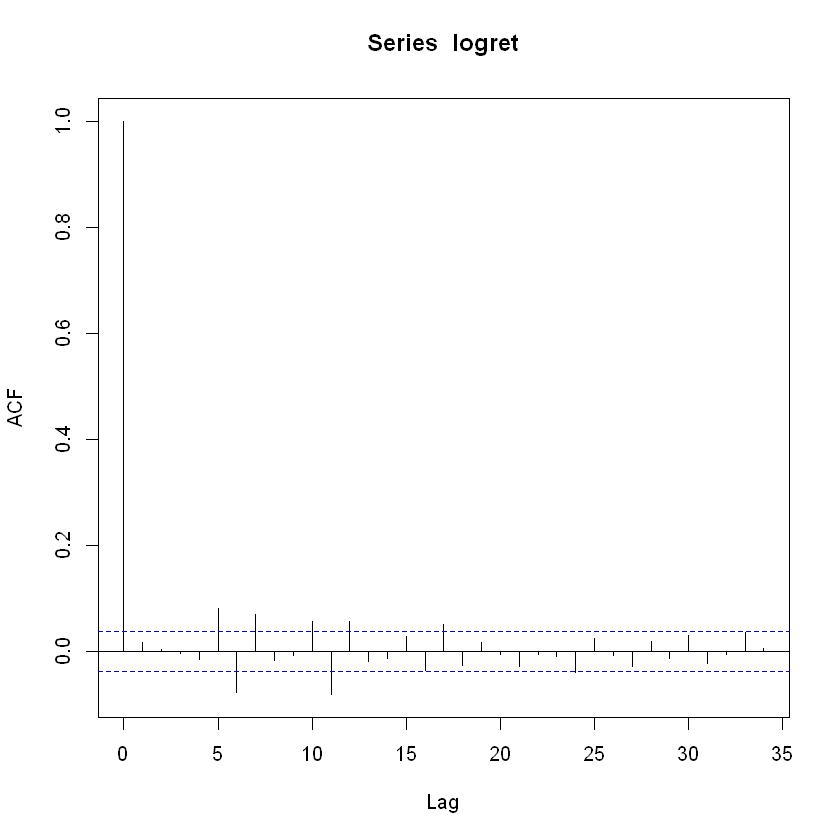

In [18]:
#Using the acf function to look for auto-correlation coefficient at different lags in the Time-Series data
acf(logret)


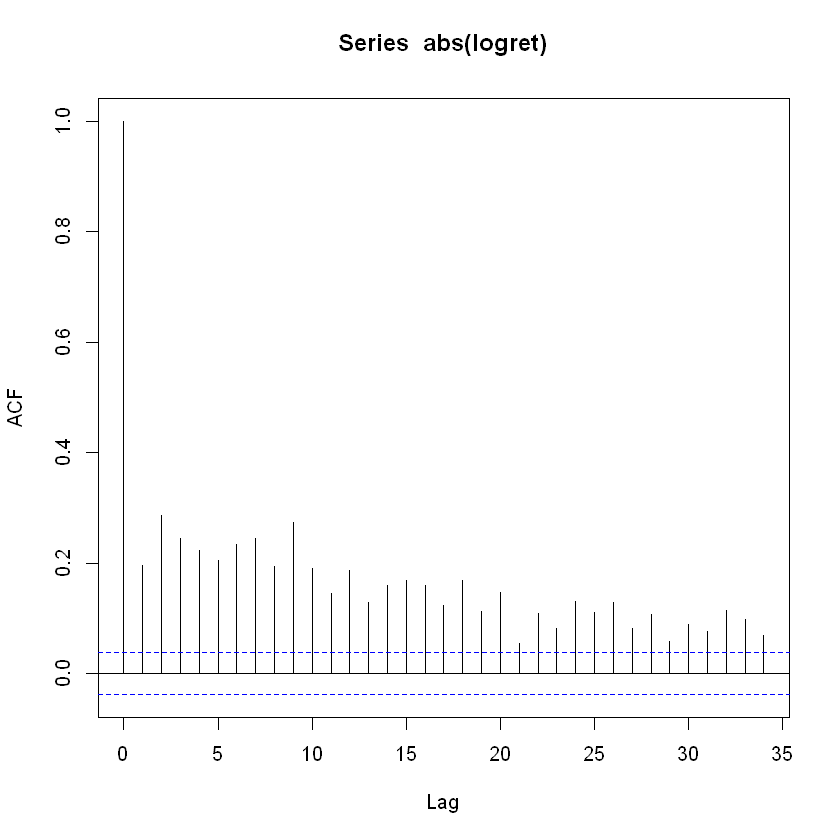

In [19]:
#Coming to the concept of Volatility Clustering,
#Volatility bursts are a type of absolute autocorrelation.
#So, it makes sense to look for auto correlation in absolute log returns data.
acf(abs(logret))

In [20]:
#Here, we can observe that the correlation coefficients are significant which implies that there can be significant 
#amount of Volatility Clustering in our data. Consequently, to deal with such circumstances, GARCH models are used in 
#practice in Risk Management which account for "Volatility Clustering".

library(rugarch)
#Fitting the Specifications we want in our GARCH model in uspec such as distribution model as Student-T Distribution,etc. Basically, we are using GARCH-(1,1)-t Model here.
uspec <-ugarchspec(variance.model = list(model="sGARCH",garchOrder =c(1,1)),
                   mean.model = list(armaOrder=c(0,0),include.mean=TRUE),
                   distribution.model = "std")

garch.fit<-ugarchfit(uspec,data=rvec)

round(garch.fit@fit$coef,6)

mu    omega   alpha1    beta1    shape 
0.000739 0.000002 0.070533 0.912189 7.532304

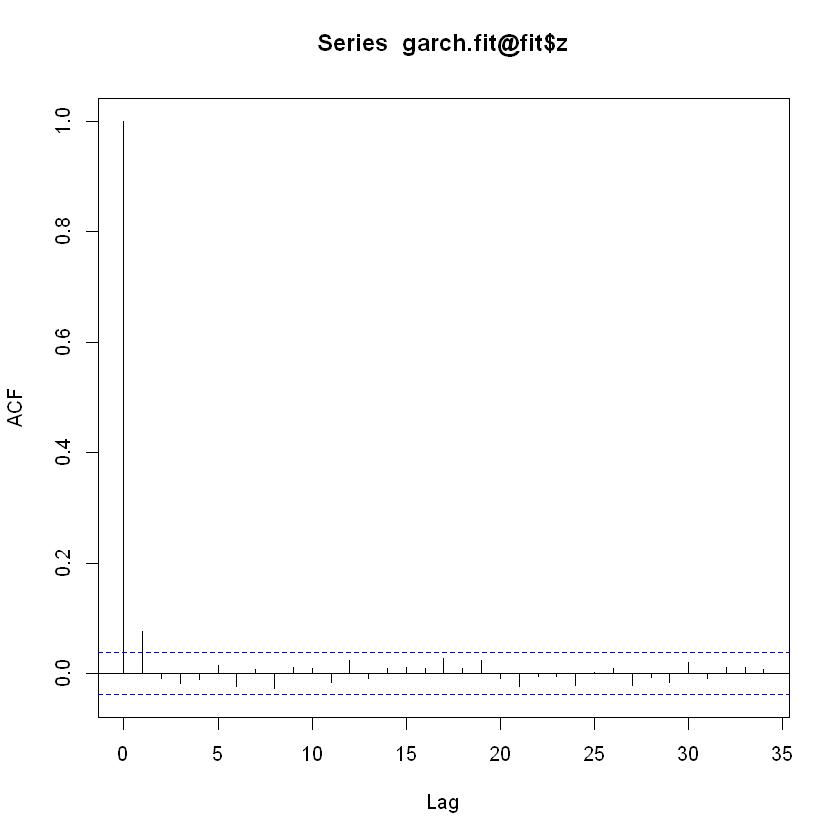

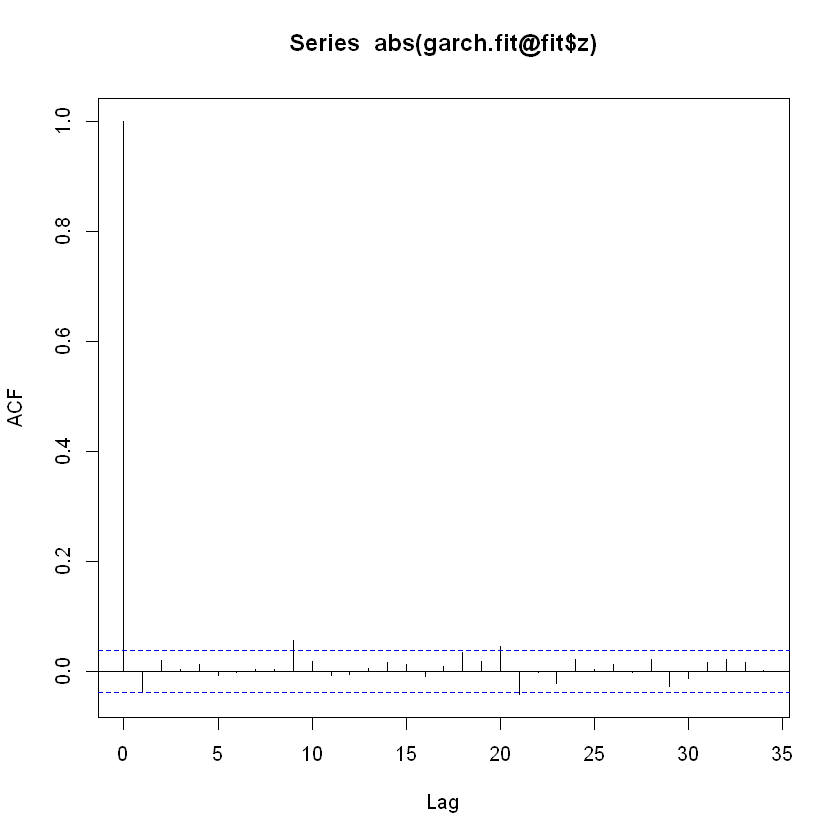

In [21]:
acf(garch.fit@fit$z)
acf(abs(garch.fit@fit$z))


In [22]:
#Using ugarchboot function for Simulation of 100000 outcomes to calculate for VaR and ES.
RNGkind(sample.kind = "Rounding")
set.seed(123789)
boot.garch = ugarchboot(garch.fit,
                        method ="Partial",
                        sampling="raw",
                        n.ahead=1,
                        n.bootpred=100000,
                        solver="solnp"
)

rvec8<-boot.garch@fseries
VaR8<-unname(quantile(rvec8,alpha))
ES8<-mean(rvec8[rvec8<VaR8])

cat("At 95% Confidence Interval\n") 
cat("VaR:", round(VaR8,6), "\n", sep = " ")
cat("ES:", round(ES8,6), sep=" ")

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


At 95% Confidence Interval
VaR: -0.015536 
ES: -0.021657

In [23]:
#Calculating Discrete returns from VaR
round((exp(VaR8)-1),6)

# Let us assume an investor invests Rs.10,00,000 in NIFTY50 Index, so according to historical GARCH predicted 
#VaR, the maximum amount that the investor can lose on the next trading session within 95% Confidence Level 
#= 10,00,000 * -0.015416 = 15,416/-Rs.

[1] -0.015416

# Calculating rolling 95% confidence interval VaR for NIFTY50 Index for 2021

In [24]:
#Preparing VaR data from 2021-01-01 upto 2021-12-31 using Ugarchroll function:-
n2020<-length(logret["2007-09-18/2020-12-31"])
roll.garch<-ugarchroll(spec=uspec,
                       data=logret,
                       n.ahead=1,
                       forecast.length=1,
                       n.start=n2020,
                       refit.every=1,
                       refit.window="recursive",
                       calculate.VaR = TRUE,
                       VaR.alpha=0.05,
                       keep.coef=TRUE)


NIFTY2021_VaR95 <- roll.garch@forecast$VaR
date <- row.names.data.frame(roll.garch@forecast$VaR)

NIFTY2021_VaR95 <- as.data.table(cbind(date,NIFTY2021_VaR95))
NIFTY2021_VaR95[,date:=lubridate::ymd(date)]
head(NIFTY2021_VaR95,3)

date,alpha(5%),realized
<date>,<dbl>,<dbl>
2021-01-01,-0.01502027,0.002624978
2021-01-04,-0.01450270,0.008127555
2021-01-05,-0.01432493,0.004701312


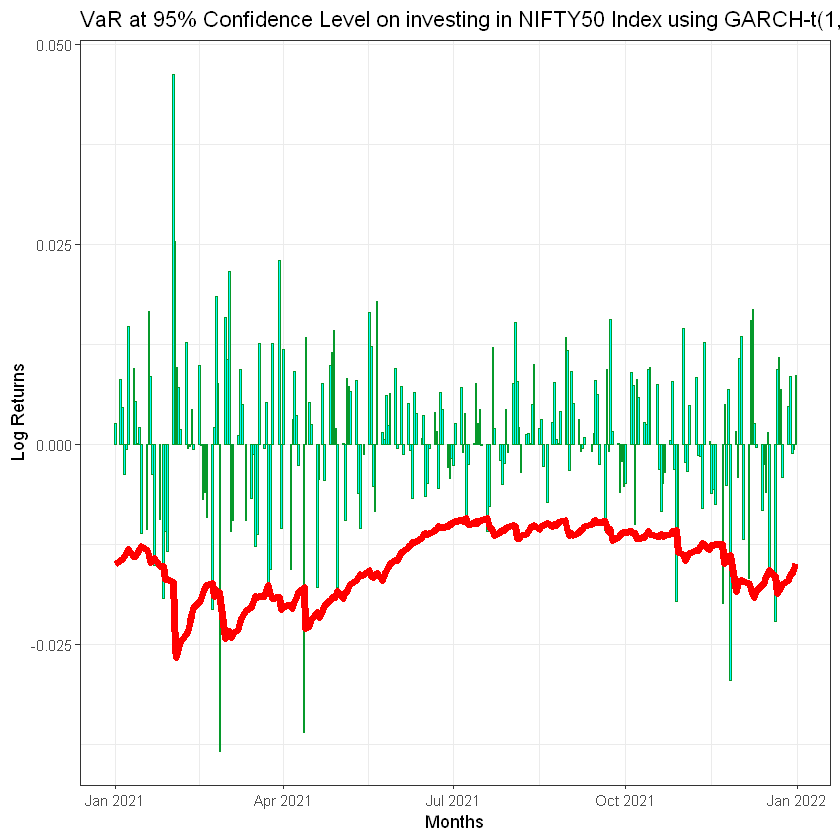

In [25]:
# Plotting Predicted VaR at 95% Confidence Level and Realized Log Returns Data from "2021-01-01" to "2021-12-31". 
ggplot(NIFTY2021_VaR95,aes(x=date)) +
  geom_col(aes(y=realized), fill = "cyan", color="#06992b") +
  geom_line(aes(y=`alpha(5%)`), col="red", size = 2) +
  labs(title= "VaR at 95% Confidence Level on investing in NIFTY50 Index using GARCH-t(1,1)",
       x="Months",y="Log Returns") +
  theme_bw()

In [26]:
cat("Total Number of NIFTY50 Trading days in year 2021:", nrow(NIFTY2021_VaR95), "\n", sep=" ")
cat("Number of trading days on which the actual losses breached the 95% confidence bar:", nrow(NIFTY2021_VaR95[(`alpha(5%)` > realized)]), "\n", sep=" ")
cat("Accuracy of Model: ", (1-nrow(NIFTY2021_VaR95[(`alpha(5%)` > realized)])/nrow(NIFTY2021_VaR95))*100, "%", sep="")

#So, we can observe that out of 248 trading days from "2021-01-01" to "2021-12-31", there are only 13 trading days(5.24%) 
#at which observed losses have breached the losses as predicted by the GARCH model at 95% Confidence Level.
#So, GARCH model is really a good estimator of VaR and ES which takes Volatility Clustering into account and provides 
#much accurate results in comparison to Normal Distributions.

#Similar calculations can be performed by setting alpha = 0.1 or 0.01 i.e., calculating 0.1th or 0.01th quantile for 
#estimating VaR and ES at 90% or 99% confidence level respectively. 

Total Number of NIFTY50 Trading days in year 2021: 248 
Number of trading days on which the actual losses breached the 95% confidence bar: 13 
Accuracy of Model: 94.75806%